# Multimodal Retrieval with Text Embedding and CLIP Image Embedding

### tech stack
     * OpenAI CLIP - ViT-B/32
     * BGE Embedding - BAAI/bge-base-en-v1.5
     * Query LLM - GPT-3.5-turbo

[image-1]:	https://media.licdn.com/dms/image/D5622AQEq0Mjbv1rJMQ/feedshare-shrink_2048_1536/0/1700773828054?e=1703721600&v=beta&t=b5R8P5zbxTscOEQENa1OheGk97wwL4luuwl4vMwx33o "image-1"

[![image-1][]][image-1]

In [1]:
!mkdir data
!mkdir images

# download webpage into html file and store it locally
!curl https://abcbirds.org/blog/backyard-birds/ --output ./data/backyard-birds.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162k  100  162k    0     0  80561      0  0:00:02  0:00:02 --:--:-- 80684


In [1]:
import clip
import torch
import replicate
import numpy as np
import qdrant_client
from pathlib import Path
from llama_index import (
                        ServiceContext,
                        SimpleDirectoryReader,
                        )
import yaml, os, openai, textwrap
from llama_index import download_loader
from llama_index.schema import ImageDocument
from llama_index.embeddings import HuggingFaceEmbedding
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.vector_stores import VectorStoreQuery
from llama_index import set_global_service_context
from llama_index.llm_predictor import LLMPredictor
from llama_index.llms import AzureOpenAI

/Users/1zuu/miniforge3/envs/llamaindex/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['REPLICATE_API_TOKEN'] = credentials['REPLICATE_API_TOKEN']

In [3]:
chat_llm = LLMPredictor(
                        llm=AzureOpenAI(
                                        deployment_name=credentials['AD_DEPLOYMENT_ID'],
                                        model=credentials['AD_ENGINE'],
                                        api_key=credentials['AD_OPENAI_API_KEY'],
                                        api_version=credentials['AD_OPENAI_API_VERSION'],
                                        azure_endpoint=credentials['AD_OPENAI_API_BASE']
                                        )
                        )
embedding_llm = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

service_context = ServiceContext.from_defaults(
                                                llm_predictor=chat_llm,
                                                embed_model=embedding_llm,
                                                )

set_global_service_context(service_context)

In [4]:
UnstructuredReader = download_loader('UnstructuredReader')
dir_reader = SimpleDirectoryReader(
                                  './data', 
                                  file_extractor={
                                              ".html": UnstructuredReader()
                                            }) # load all of the unstructured data files from the ./data/ directory into a list.
documents = dir_reader.load_data()
print(f'Loaded {len(documents)} documents')

[nltk_data] Downloading package punkt to /Users/1zuu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/1zuu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loaded 1 documents


In [5]:
image_metadata_dict = {}

# Get a list of all the image files in the `images` folder.
image_files = os.listdir("images")

# Loop through each image file and add metadata.
for image_file in image_files:
    image_path = os.path.join("images", image_file)
    # Get the image filename.
    image_filename = os.path.basename(image_path)

    # Get the image file path.
    image_file_path = os.path.abspath(image_path)

    # Create a dictionary to store the image metadata.
    image_metadata_dict[image_filename] = {
      "filename": image_filename,
      "img_path": image_file_path,
    }

In [6]:
image_metadata_dict

{'Get-Involved_conservbirding_meganav-thumb_marvspat_dubi-shapiro.png': {'filename': 'Get-Involved_conservbirding_meganav-thumb_marvspat_dubi-shapiro.png',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/06-multimodal-rag-open-source/images/Get-Involved_conservbirding_meganav-thumb_marvspat_dubi-shapiro.png'},
 'finch-at-feeder-512x341.jpg': {'filename': 'finch-at-feeder-512x341.jpg',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/06-multimodal-rag-open-source/images/finch-at-feeder-512x341.jpg'},
 'Northern-Cardinal-map_ABC-1.jpg': {'filename': 'Northern-Cardinal-map_ABC-1.jpg',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/06-multimodal-rag-open-source/images/Northern-Cardinal-map_ABC-1.jpg'},
 'Golden-winged_Warbler_Lynda-Goff_thumb.jpg': {'filename': 'Golden-winged_Warbler_Lynda-Goff_thumb.jpg',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/06-multimodal-rag-open-source/images/Golden-winged_War

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# a simple and useful way to plot multiple images in a grid
def plot_images(image_metadata_dict):
    images = []
    images_shown = 0
    for image_filename in image_metadata_dict:
        img_path = image_metadata_dict[image_filename]["img_path"]
        if os.path.isfile(img_path):
            # open the image file and convert it to RGB colorspace.
            filename = image_metadata_dict[image_filename]["filename"]
            try:
                image = Image.open(img_path).convert("RGB")
                # plot the image in a subplot of an 8x8 grid, also disables the tick labels on the axes to make the plot cleaner.
                plt.subplot(8, 8, len(images) + 1)
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])

                images.append(filename)
                images_shown += 1
                if images_shown >= 64:
                    break
                
            except:
                pass

    plt.tight_layout()
    plt.show()

/Users/1zuu/miniforge3/envs/llamaindex/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


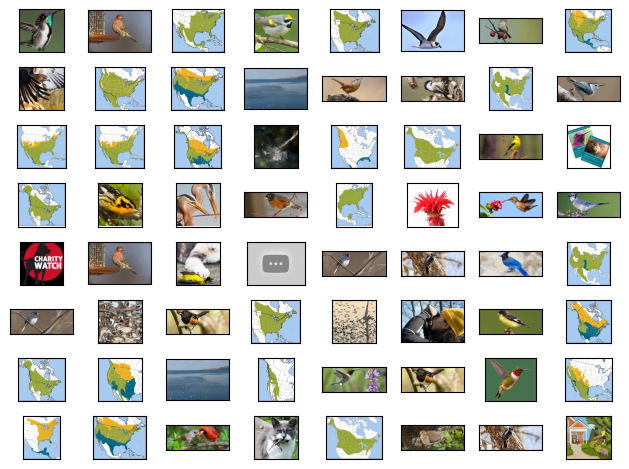

In [8]:
plot_images(image_metadata_dict)

In [9]:
text_client = qdrant_client.QdrantClient(location=":memory:")
text_vector_store = QdrantVectorStore(
                                    client=text_client, 
                                    collection_name="birds_text"
                                    )
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)
text_documents = SimpleDirectoryReader("./data").load_data()

birds_text_index = VectorStoreIndex.from_documents(
                                                    text_documents,
                                                    storage_context=storage_context
                                                    )

# define text query engine
text_query_engine = birds_text_index.as_query_engine()

In [10]:
model, preprocess = clip.load("ViT-B/32")
model = model.to("mps")
input_resolution = model.visual.input_resolution


context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [11]:
device = "mps"
print("Consuming:", device)

img_emb_dict = {}
with torch.no_grad():
    for image_filename in image_metadata_dict:
        img_file_path = image_metadata_dict[image_filename]["img_path"]
        if os.path.isfile(img_file_path):
            try:
                image = (
                    preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
                )
                image_features = model.encode_image(image)
                img_emb_dict[image_filename] = image_features
            except:
                pass

Consuming: mps


In [12]:
img_documents = []
for image_filename in image_metadata_dict:
    # the img_emb_dict dictionary contains the image embeddings
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]

        # create an ImageDocument for each image
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )

        # set image embedding on the ImageDocument
        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

# create QdrantVectorStore, with collection name "birds_img"
image_vector_store = QdrantVectorStore(
                                    client=text_client, 
                                    collection_name="birds_img"
                                    )

# define storage context
storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

# define image index
image_index = VectorStoreIndex.from_documents(
                                            img_documents,
                                            storage_context=storage_context
                                            )

In [13]:
def retrieve_results_from_image_index(query):
    text = clip.tokenize(query).to(device)
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
                                                query_embedding=query_embedding,
                                                similarity_top_k=1, # only return 1 image
                                                mode="default",
                                                )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results

In [33]:
def plot_image_retrieve_results(
                                image_retrieval_results,
                                url_prefix = 'https://dariuszzdziebk.wpenginepowered.com/wp-content/uploads/2022/09/'
                                ):
    plt.figure(figsize=(16, 5))

    img_cnt = 0
    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The subplot is 2 by 3, and the image is displayed in the img_cnt + 1th subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.
    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

        image_path_split = img_path.split(".")
        image_url = url_prefix + img_name.replace(image_path_split[-2], '')
        return image_url
    
def llava_inference(
                    image,
                    prompt,
                    max_tokens = 100,
                    temperature = 0.5
                    ):
    output = replicate.run(
                            "yorickvp/llava-13b:c293ca6d551ce5e74893ab153c61380f5bcbd80e02d49e08c582de184a8f6c83",
                            input={
                                    "image": image,
                                    "prompt": prompt,
                                    "max_tokens": max_tokens,
                                    "temperature": temperature
                                    }
                        )
    return output

In [25]:
def multimodal_retrivial(
                        query,
                        prompt = """
                        Consider below context to improve the quality of the answer. do not change the context or hallucinate information.

                        {context}
                        """):
    image_retrieval_results = retrieve_results_from_image_index(query)
    image_url = plot_image_retrieve_results(image_retrieval_results)
    context = str(text_query_engine.query(query))

    output = llava_inference(
                            image_url,
                            prompt.format(context=context)
                            )
    return output